# SHAP STATE III feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [ ]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 1
repeats = 10
min_genes = 5
max_genes = 14
importance_type = "split"

life_history = ["lifespan", "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
trait = "lifespan"
debug_local = True #to use local version

In [ ]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

In [ ]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics

In [ ]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [ ]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import pprint
pp = pprint.PrettyPrinter(indent=4)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [ ]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [ ]:
from loguru import logger
logger.add(locations.logs / "stage_two_shap_selection.log", rotation="12:00")     # New file is created each day at noon

In [59]:
stage_3_folder = locations.interim.dir / "stage_3" 
stage_3_folder.mkdir(exist_ok=True)
partitions_folder = stage_3_folder  / "partitions"
partitions_folder.mkdir(exist_ok=True)

In [ ]:
data = ExpressionDataset.from_folder(locations.interim.dir / "stage_2" / "input")
data

### Loading genes from the ranked selection ###

In [61]:
intersections = locations.output.intersections
ranked = pd.read_csv(intersections / "intersections_ranked.tsv", sep="\t", index_col="reference_gene")
print(ranked.shape)
ranked.head(10)

(51, 19)


symbol   rank  ranks_sum  repeats_rank  shap_rank  \
reference_gene                                                        
ENSG00000170835      CEL  1.000     20.500         3.500      6.000   
ENSG00000105672     ETV2  2.000     22.500         3.500      5.000   
ENSG00000188747    NOXA1  3.000     36.000        12.000     12.000   
ENSG00000165501     LRR1  4.000     37.500         8.500     21.000   
ENSG00000171121   KCNMB3  5.000     41.000        12.000     10.000   
ENSG00000137411    VARS2  6.000     44.000        17.000     17.000   
ENSG00000165555  NOXRED1  7.000     45.000        12.000     32.000   
ENSG00000142002     DPP9  8.000     45.500        14.500     27.000   
ENSG00000010219    DYRK4  9.000     47.500         3.500      1.000   
ENSG00000204498  NFKBIL1 10.000     49.500         3.500      2.000   

                 kendall_tau_rank  frequency_rank  repeats_all  repeats  \
reference_gene                                                            
ENSG00000170835            11.000           4.000       20.000   10.000   
ENSG00000105672            14.000          32.000       20.000   10.000   
ENSG00000188747            12.000           1.000       18.000    9.000   
ENSG00000165501             8.000           6.000       19.000   10.000   
ENSG00000171121            19.000           3.000       18.000   10.000   
ENSG00000137411            10.000          32.000       16.000   10.000   
ENSG00000165555             1.000          32.000       18.000   10.000   
ENSG00000142002             4.000           8.000       17.000   10.000   
ENSG00000010219            43.000          32.000       20.000   10.000   
ENSG00000204498            44.000          32.000       20.000   10.000   

                 mean_abs_shap  mean_kendall_tau  frequency    direction  \
reference_gene                                                             
ENSG00000170835          0.966             0.694      0.600   strong pro   
ENSG00000105672          1.114             0.669      0.000   strong pro   
ENSG00000188747          0.551             0.689      1.000   strong pro   
ENSG00000165501          0.385             0.717      0.340   strong pro   
ENSG00000171121          0.614             0.640      0.720   strong pro   
ENSG00000137411          0.431            -0.698      0.000  strong anti   
ENSG00000165555          0.221             0.811      0.000   strong pro   
ENSG00000142002          0.317            -0.773      0.300  strong anti   
ENSG00000010219          2.511             0.440      0.000          pro   
ENSG00000204498          2.020            -0.420      0.000         anti   

                 repeats_lifespan_stage_1  mean_abs_shap_lifespan_stage_1  \
reference_gene                                                              
ENSG00000170835                    10.000                           1.068   
ENSG00000105672                    10.000                           1.018   
ENSG00000188747                     9.000                           0.413   
ENSG00000165501                     9.000                           0.177   
ENSG00000171121                     8.000                           0.586   
ENSG00000137411                     6.000                           0.238   
ENSG00000165555                     8.000                           0.076   
ENSG00000142002                     7.000                           0.101   
ENSG00000010219                    10.000                           2.384   
ENSG00000204498                    10.000                           1.859   

                 mean_kendall_tau_lifespan_stage_1 direction_lifespan_stage_1  \
reference_gene                                                                  
ENSG00000170835                              0.693                 strong pro   
ENSG00000105672                              0.713                 strong pro   
ENSG00000188747                              0.689                 strong pro   
ENSG00000165501      

In [ ]:
def data_genes(genes: List[str]):
    return data.by_genes.collect(lambda gs: gs.loc[genes])

def data_head(num: int):
    return data_genes(ranked.head(num).index.to_list())

## Setting up features to select ##

In [ ]:
default_selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent"
)
default_selection

In [ ]:
def selection(num: int, trait: str = "lifespan"):
    d = data_head(num)
    return (d,  replace(default_selection, to_predict = trait, not_validated_species = d.min_max_trait(trait) ))
selection(10)[1]

### Setting up pipelines ###

In [ ]:
from yspecies.helpers import PipelineFactory
factory = PipelineFactory(locations, repeats, n_folds, n_hold_out)

In [ ]:
def opt_by_trait(trait: str, sufix: str = ""):
    return locations.interim.optimization / f"{trait}{sufix}.sqlite"

In [ ]:
lifespan_pipeline = factory.make_repeated_shap_pipeline(study_path = opt_by_trait(trait), study_name=f"{trait}_r2_huber_kendall")
#pipelines = {trait:factory.make_shap_pipeline(trait) for trait in life_history}
lifespan_pipeline

# Run three stage #

In [62]:
all_ranked_results = lifespan_pipeline.fit_transform(selection(ranked.shape[0],"lifespan"))
all_ranked_results.plot()

2020-11-05 11:45:02.311 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-05 11:45:02.312 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-05 11:45:02.316 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:45:16.711 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Early stopping, best iteration is:
[164]	valid_0's l1: 7.51752	valid_0's l2: 147.717	valid_0's huber: 6.40593
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:45:27.328 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Early stopping, best iteration is:
[117]	valid_0's l1: 2.89124	valid_0's l2: 31.7228	valid_0's huber: 2.26482
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:45:39.808 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Early stopping, best iteration is:
[132]	valid_0's l1: 2.96119	valid_0's l2: 22.7324	valid_0's huber: 2.31242
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 3.04745	valid_0's l2: 45.6549	valid_0's huber: 2.39141


2020-11-05 11:45:57.224 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9188281293655154, MAE=4.104348767523075, MSE=61.95686817434565, huber=3.3447561695911068)
2020-11-05 11:45:57.230 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-05 11:45:57.231 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-05 11:45:57.234 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engi

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:46:11.851 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Early stopping, best iteration is:
[169]	valid_0's l1: 2.47086	valid_0's l2: 16.8208	valid_0's huber: 1.89998
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:46:27.060 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[173]	valid_0's l1: 3.85401	valid_0's l2: 54.032	valid_0's huber: 3.12046
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:46:37.676 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Early stopping, best iteration is:
[116]	valid_0's l1: 3.01196	valid_0's l2: 22.8902	valid_0's huber: 2.37526
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 3.77681	valid_0's l2: 57.7845	valid_0's huber: 3.07289


2020-11-05 11:46:54.519 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9464479305231547, MAE=3.2784116050388232, MSE=37.88190754572426, huber=2.616460002953568)
2020-11-05 11:46:54.524 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-05 11:46:54.525 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-05 11:46:54.528 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/light

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:47:04.801 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Early stopping, best iteration is:
[115]	valid_0's l1: 3.04932	valid_0's l2: 18.4047	valid_0's huber: 2.37139
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:47:15.134 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[111]	valid_0's l1: 3.38449	valid_0's l2: 58.441	valid_0's huber: 2.70939
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:47:22.643 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Early stopping, best iteration is:
[84]	valid_0's l1: 3.49756	valid_0's l2: 25.6344	valid_0's huber: 2.78891
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[218]	valid_0's l1: 4.81706	valid_0's l2: 76.4445	valid_0's huber: 3.98331


2020-11-05 11:47:49.029 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.925830903696288, MAE=3.6871066108077843, MSE=44.731134018740995, huber=2.9632904887385694)
2020-11-05 11:47:49.035 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-05 11:47:49.035 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-05 11:47:49.039 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:48:00.280 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[121]	valid_0's l1: 3.35068	valid_0's l2: 23.5486	valid_0's huber: 2.64799
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:48:19.250 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Early stopping, best iteration is:
[210]	valid_0's l1: 5.65074	valid_0's l2: 87.0298	valid_0's huber: 4.71911
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:48:32.244 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Early stopping, best iteration is:
[145]	valid_0's l1: 2.95179	valid_0's l2: 25.9941	valid_0's huber: 2.32596
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 2.4198	valid_0's l2: 29.2701	valid_0's huber: 1.84062


2020-11-05 11:48:48.929 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9437017173612676, MAE=3.593251707284685, MSE=41.46063492632386, huber=2.8843167970019135)
2020-11-05 11:48:48.934 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-05 11:48:48.934 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-05 11:48:48.938 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:49:00.367 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Early stopping, best iteration is:
[127]	valid_0's l1: 2.93633	valid_0's l2: 19.0123	valid_0's huber: 2.29334
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:49:09.910 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Early stopping, best iteration is:
[115]	valid_0's l1: 3.19491	valid_0's l2: 36.581	valid_0's huber: 2.52761
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:49:22.210 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[130]	valid_0's l1: 2.85878	valid_0's l2: 20.4617	valid_0's huber: 2.24337
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's l1: 5.40749	valid_0's l2: 91.4452	valid_0's huber: 4.51265


2020-11-05 11:49:43.376 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9432965753398534, MAE=3.599375266953909, MSE=41.875054421179016, huber=2.893981324281366)
2020-11-05 11:49:43.382 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-05 11:49:43.383 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-05 11:49:43.388 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/ligh

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:50:02.071 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Early stopping, best iteration is:
[219]	valid_0's l1: 2.48805	valid_0's l2: 16.2183	valid_0's huber: 1.89451
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:50:12.969 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[115]	valid_0's l1: 4.01058	valid_0's l2: 58.926	valid_0's huber: 3.25181
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:50:29.518 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[187]	valid_0's l1: 5.13534	valid_0's l2: 91.9516	valid_0's huber: 4.27455
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[113]	valid_0's l1: 3.93783	valid_0's l2: 80.376	valid_0's huber: 3.20947


2020-11-05 11:50:47.081 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9146730798464426, MAE=3.8929516484987667, MSE=61.867996426788665, huber=3.159205715965262)
2020-11-05 11:50:47.086 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-05 11:50:47.087 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-05 11:50:47.090 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pa

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:50:56.761 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Early stopping, best iteration is:
[111]	valid_0's l1: 3.11862	valid_0's l2: 30.2926	valid_0's huber: 2.45575
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:51:09.008 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Early stopping, best iteration is:
[138]	valid_0's l1: 2.82448	valid_0's l2: 28.5008	valid_0's huber: 2.20641
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:51:18.228 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Early stopping, best iteration is:
[100]	valid_0's l1: 2.69363	valid_0's l2: 22.2906	valid_0's huber: 2.06893
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 3.0092	valid_0's l2: 32.7524	valid_0's huber: 2.37085


2020-11-05 11:51:36.409 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9606135024681965, MAE=2.911484618252141, MSE=28.45910730204458, huber=2.271830129610321)
2020-11-05 11:51:36.417 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-05 11:51:36.418 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-05 11:51:36.421 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:51:53.589 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Early stopping, best iteration is:
[196]	valid_0's l1: 3.74633	valid_0's l2: 27.6318	valid_0's huber: 3.01571
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:52:11.407 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Early stopping, best iteration is:
[198]	valid_0's l1: 3.00771	valid_0's l2: 42.4489	valid_0's huber: 2.37924
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:52:26.041 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Early stopping, best iteration is:
[167]	valid_0's l1: 3.69106	valid_0's l2: 33.9885	valid_0's huber: 2.97833
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 4.27506	valid_0's l2: 40.5705	valid_0's huber: 3.4914


2020-11-05 11:52:41.245 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9497656541314616, MAE=3.680040907075595, MSE=36.15991890520279, huber=2.967208830905853)
2020-11-05 11:52:41.250 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-05 11:52:41.251 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-05 11:52:41.254 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/en

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:52:48.965 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Early stopping, best iteration is:
[86]	valid_0's l1: 2.52503	valid_0's l2: 19.2516	valid_0's huber: 1.91071
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:52:59.306 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Early stopping, best iteration is:
[117]	valid_0's l1: 2.89544	valid_0's l2: 26.4541	valid_0's huber: 2.26814
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:53:12.155 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Early stopping, best iteration is:
[151]	valid_0's l1: 3.21683	valid_0's l2: 35.816	valid_0's huber: 2.56689
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 2.49676	valid_0's l2: 23.2631	valid_0's huber: 1.91647


2020-11-05 11:53:32.746 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9637805022579691, MAE=2.783516395678981, MSE=26.196203907637592, huber=2.1646223389208994)
2020-11-05 11:53:32.752 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-05 11:53:32.752 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-05 11:53:32.756 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-package

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:53:46.692 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[152]	valid_0's l1: 2.83173	valid_0's l2: 17.2954	valid_0's huber: 2.21563
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:53:57.929 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[130]	valid_0's l1: 4.15534	valid_0's l2: 57.4208	valid_0's huber: 3.39778
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:54:09.273 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Early stopping, best iteration is:
[125]	valid_0's l1: 3.3053	valid_0's l2: 30.6705	valid_0's huber: 2.62694
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[98]	valid_0's l1: 4.65784	valid_0's l2: 68.3856	valid_0's huber: 3.86541


2020-11-05 11:54:25.768 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9409059298430296, MAE=3.737553410555996, MSE=43.44309523384047, huber=3.0289425616690435)


In [ ]:
lifespan_results = [lifespan_pipeline.fit_transform(selection(i,"lifespan")) for i in range(min_genes, max_genes)] #all genes
len(lifespan_results)

2020-11-05 11:25:00.060 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 0 =====
2020-11-05 11:25:00.061 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 9}
2020-11-05 11:25:00.065 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:25:14.545 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Early stopping, best iteration is:
[164]	valid_0's l1: 7.51752	valid_0's l2: 147.717	valid_0's huber: 6.40593
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:25:24.428 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Early stopping, best iteration is:
[117]	valid_0's l1: 2.89124	valid_0's l2: 31.7228	valid_0's huber: 2.26482
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:25:36.823 | INFO     | yspecies.selection:fit:161 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Early stopping, best iteration is:
[132]	valid_0's l1: 2.96119	valid_0's l2: 22.7324	valid_0's huber: 2.31242
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 3.04745	valid_0's l2: 45.6549	valid_0's huber: 2.39141


2020-11-05 11:25:54.198 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9188281293655154, MAE=4.104348767523075, MSE=61.95686817434565, huber=3.3447561695911068)
2020-11-05 11:25:54.206 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 1 =====
2020-11-05 11:25:54.206 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-11-05 11:25:54.210 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/engi

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:26:08.712 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Early stopping, best iteration is:
[169]	valid_0's l1: 2.47086	valid_0's l2: 16.8208	valid_0's huber: 1.89998
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:26:23.979 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[173]	valid_0's l1: 3.85401	valid_0's l2: 54.032	valid_0's huber: 3.12046
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:26:34.724 | INFO     | yspecies.selection:fit:161 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Early stopping, best iteration is:
[116]	valid_0's l1: 3.01196	valid_0's l2: 22.8902	valid_0's huber: 2.37526
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's l1: 3.77681	valid_0's l2: 57.7845	valid_0's huber: 3.07289


2020-11-05 11:26:51.639 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9464479305231547, MAE=3.2784116050388232, MSE=37.88190754572426, huber=2.616460002953568)
2020-11-05 11:26:51.645 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 2 =====
2020-11-05 11:26:51.646 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-11-05 11:26:51.649 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/light

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:27:02.091 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Early stopping, best iteration is:
[115]	valid_0's l1: 3.04932	valid_0's l2: 18.4047	valid_0's huber: 2.37139
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:27:11.646 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[111]	valid_0's l1: 3.38449	valid_0's l2: 58.441	valid_0's huber: 2.70939
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:27:19.800 | INFO     | yspecies.selection:fit:161 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Early stopping, best iteration is:
[84]	valid_0's l1: 3.49756	valid_0's l2: 25.6344	valid_0's huber: 2.78891
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[218]	valid_0's l1: 4.81706	valid_0's l2: 76.4445	valid_0's huber: 3.98331


2020-11-05 11:27:45.607 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.925830903696288, MAE=3.6871066108077843, MSE=44.731134018740995, huber=2.9632904887385694)
2020-11-05 11:27:45.613 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 3 =====
2020-11-05 11:27:45.614 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-11-05 11:27:45.617 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:27:56.723 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[121]	valid_0's l1: 3.35068	valid_0's l2: 23.5486	valid_0's huber: 2.64799
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:28:15.849 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Early stopping, best iteration is:
[210]	valid_0's l1: 5.65074	valid_0's l2: 87.0298	valid_0's huber: 4.71911
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:28:28.773 | INFO     | yspecies.selection:fit:161 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Early stopping, best iteration is:
[145]	valid_0's l1: 2.95179	valid_0's l2: 25.9941	valid_0's huber: 2.32596
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[100]	valid_0's l1: 2.4198	valid_0's l2: 29.2701	valid_0's huber: 1.84062


2020-11-05 11:28:45.595 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9437017173612676, MAE=3.593251707284685, MSE=41.46063492632386, huber=2.8843167970019135)
2020-11-05 11:28:45.601 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 4 =====
2020-11-05 11:28:45.601 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-11-05 11:28:45.605 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightg

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:28:57.054 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Early stopping, best iteration is:
[127]	valid_0's l1: 2.93633	valid_0's l2: 19.0123	valid_0's huber: 2.29334
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:29:07.273 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Early stopping, best iteration is:
[115]	valid_0's l1: 3.19491	valid_0's l2: 36.581	valid_0's huber: 2.52761
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:29:19.191 | INFO     | yspecies.selection:fit:161 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[130]	valid_0's l1: 2.85878	valid_0's l2: 20.4617	valid_0's huber: 2.24337
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's l1: 5.40749	valid_0's l2: 91.4452	valid_0's huber: 4.51265


2020-11-05 11:29:40.265 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9432965753398534, MAE=3.599375266953909, MSE=41.875054421179016, huber=2.893981324281366)
2020-11-05 11:29:40.270 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 5 =====
2020-11-05 11:29:40.271 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-11-05 11:29:40.274 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/ligh

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:29:58.990 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Early stopping, best iteration is:
[219]	valid_0's l1: 2.48805	valid_0's l2: 16.2183	valid_0's huber: 1.89451
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:30:09.253 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[115]	valid_0's l1: 4.01058	valid_0's l2: 58.926	valid_0's huber: 3.25181
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:30:25.956 | INFO     | yspecies.selection:fit:161 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[187]	valid_0's l1: 5.13534	valid_0's l2: 91.9516	valid_0's huber: 4.27455
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[113]	valid_0's l1: 3.93783	valid_0's l2: 80.376	valid_0's huber: 3.20947


2020-11-05 11:30:42.755 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9146730798464426, MAE=3.8929516484987667, MSE=61.867996426788665, huber=3.159205715965261)
2020-11-05 11:30:42.761 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 6 =====
2020-11-05 11:30:42.762 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-11-05 11:30:42.765 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
/data/miniconda3/envs/yspecies/lib/python3.8/site-pa

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:30:50.372 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Early stopping, best iteration is:
[111]	valid_0's l1: 3.11862	valid_0's l2: 30.2926	valid_0's huber: 2.45575
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:31:02.150 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Early stopping, best iteration is:
[138]	valid_0's l1: 2.82448	valid_0's l2: 28.5008	valid_0's huber: 2.20641
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:31:11.376 | INFO     | yspecies.selection:fit:161 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Early stopping, best iteration is:
[100]	valid_0's l1: 2.69363	valid_0's l2: 22.2906	valid_0's huber: 2.06893
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[114]	valid_0's l1: 3.0092	valid_0's l2: 32.7524	valid_0's huber: 2.37085


2020-11-05 11:31:29.581 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9606135024681965, MAE=2.911484618252141, MSE=28.45910730204458, huber=2.271830129610321)
2020-11-05 11:31:29.587 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 7 =====
2020-11-05 11:31:29.587 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-11-05 11:31:29.591 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/eng

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:31:46.768 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Early stopping, best iteration is:
[196]	valid_0's l1: 3.74633	valid_0's l2: 27.6318	valid_0's huber: 3.01571
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:32:04.360 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Early stopping, best iteration is:
[198]	valid_0's l1: 3.00771	valid_0's l2: 42.4489	valid_0's huber: 2.37924
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:32:19.716 | INFO     | yspecies.selection:fit:161 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Early stopping, best iteration is:
[167]	valid_0's l1: 3.69106	valid_0's l2: 33.9885	valid_0's huber: 2.97833
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 4.27506	valid_0's l2: 40.5705	valid_0's huber: 3.4914


2020-11-05 11:32:34.912 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9497656541314616, MAE=3.680040907075595, MSE=36.15991890520279, huber=2.9672088309058533)
2020-11-05 11:32:34.918 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 8 =====
2020-11-05 11:32:34.918 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-11-05 11:32:34.921 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/lightgbm/e

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:32:42.564 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Early stopping, best iteration is:
[86]	valid_0's l1: 2.52503	valid_0's l2: 19.2516	valid_0's huber: 1.91071
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:32:52.921 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Early stopping, best iteration is:
[117]	valid_0's l1: 2.89544	valid_0's l2: 26.4541	valid_0's huber: 2.26814
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:33:06.944 | INFO     | yspecies.selection:fit:161 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Early stopping, best iteration is:
[151]	valid_0's l1: 3.21683	valid_0's l2: 35.816	valid_0's huber: 2.56689
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 2.49676	valid_0's l2: 23.2631	valid_0's huber: 1.91647


2020-11-05 11:33:27.524 | INFO     | yspecies.explanations:transform:646 - Metrics: 
Metrics(R2=0.9637805022579691, MAE=2.783516395678981, MSE=26.196203907637592, huber=2.164622338920899)
2020-11-05 11:33:27.531 | INFO     | yspecies.selection:fit:157 - ===== fitting models with seed 9 =====
2020-11-05 11:33:27.532 | INFO     | yspecies.selection:fit:158 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-11-05 11:33:27.535 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
/data/miniconda3/envs/yspecies/lib/python3.8/site-packages

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:33:41.407 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[152]	valid_0's l1: 2.83173	valid_0's l2: 17.2954	valid_0's huber: 2.21563
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-11-05 11:33:53.520 | INFO     | yspecies.selection:fit:161 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[130]	valid_0's l1: 4.15534	valid_0's l2: 57.4208	valid_0's huber: 3.39778
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


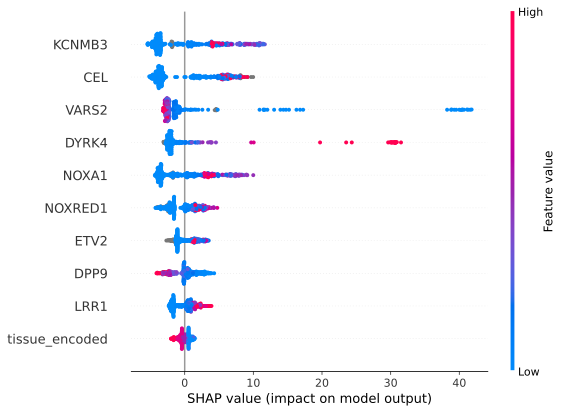

In [64]:
lifespan_results[9 - min_genes].plot(save = locations.output.plots / f"stage_3_{9}")

In [ ]:
lifespan_results[8].plot(save = locations.output.plots / f"stage_3_{min_genes + 8")

In [65]:
rs = {f"{i+min_genes}": [lifespan_results[i].metrics_average.R2] for i in range(0, len(lifespan_results))}
rs_pd = pd.DataFrame(rs, columns=rs.keys() ).T.reset_index().rename(columns={0:"R^2", "index": "genes"})
rs_pd


genes   R^2
0     5 0.454
1     6 0.640
2     7 0.698
3     8 0.764
4     9 0.841
5    10 0.874
6    11 0.898
7    12 0.904
8    13 0.903

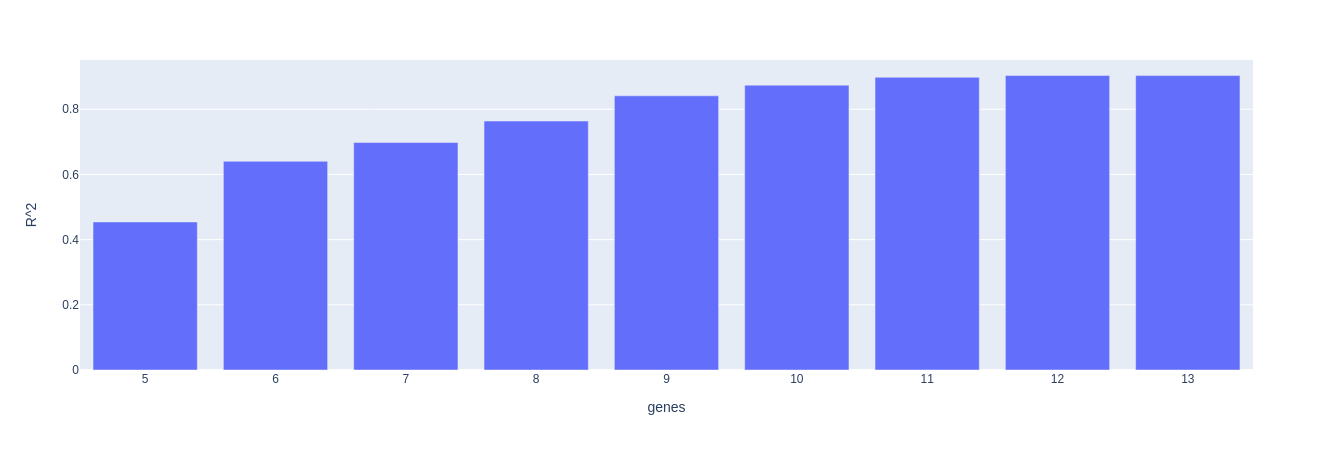

In [40]:
import plotly.express as px
fig = px.bar(rs_pd, x="genes", y="R^2")
fig

In [ ]:
lifespan_results[4].plot_decision()

In [ ]:
lifespan_results[4].plot_heatmap()

### Interaction plot ###

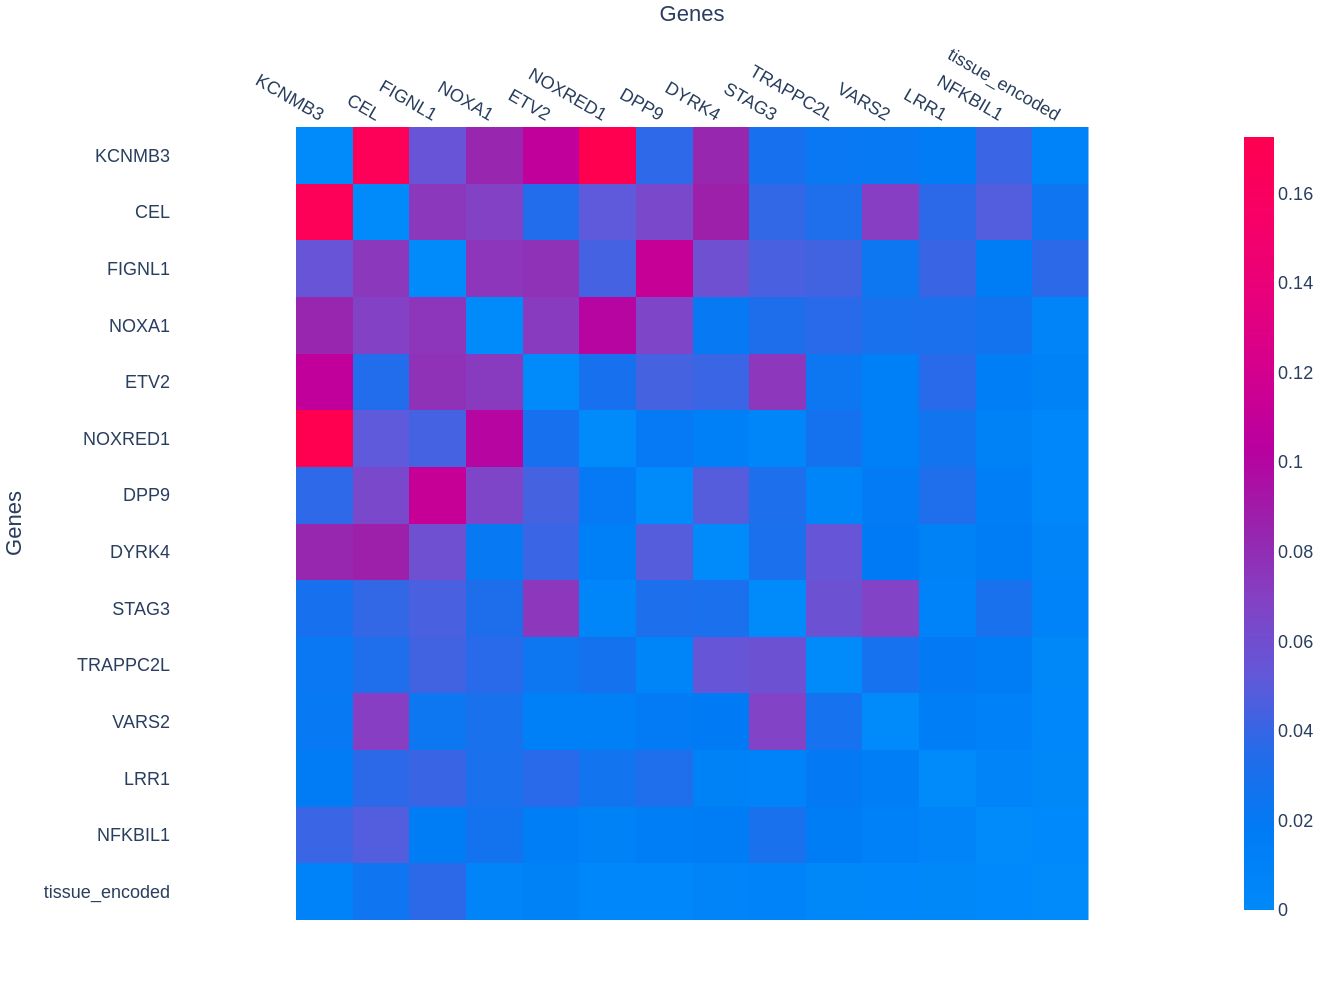

In [66]:
import plotly.io as pio
#pio.orca.config.use_xvfb = True

interactions_stage_two_plot_path = locations.output.plots / "genetic_interactions_stage_three.svg"
from yspecies.explanations import *
lifespan_results[8].plot_interactions(height=1000, width=1090, max=15, title="", axis_title="Genes")

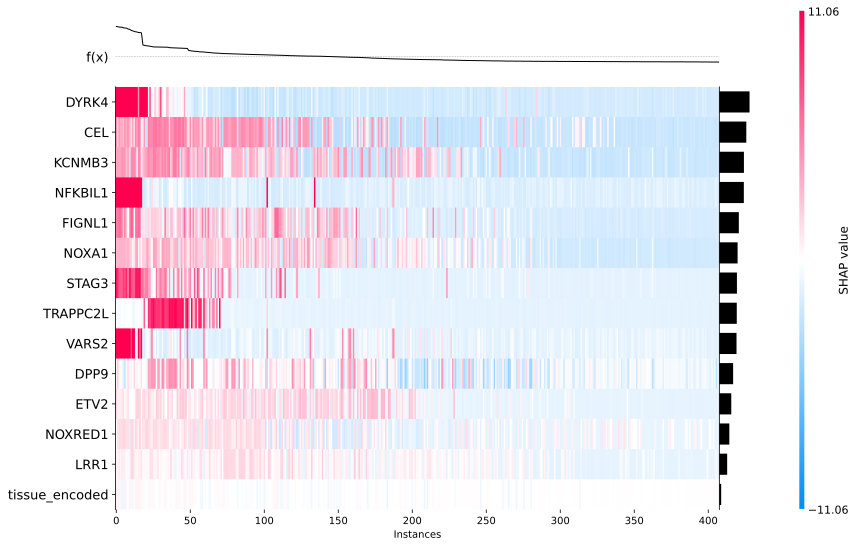

In [69]:
lifespan_results[8].plot_heatmap(sort_by_clust = False, save = locations.output.plots / "heatmap_stage_three_unclustered.svg")

min_max dataset values: (3.3, 122.5)


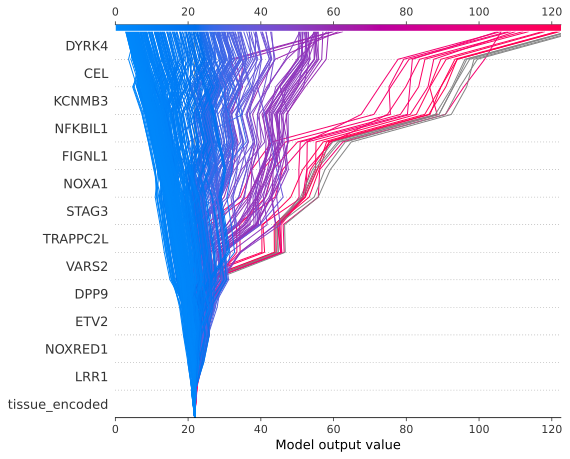

In [71]:
lifespan_results[8].plot_decision()

### Dependency plots for the most interesting interactions ###

In [ ]:
interaction_1 = locations.output.plots / "interactions" / "RNH1_STAG3.svg"
lifespan_2.plot_dependency("RNH1", "STAG3", save=interaction_1)

In [ ]:
interaction_2 = locations.output.plots / "interactions" / "RNH1_CAPN3.svg"
lifespan_2.plot_dependency("RNH1", "CAPN3", interaction_2)

In [ ]:
interaction_3 = locations.output.plots / "interactions" / "VPS28_CAPN3.svg"
lifespan_2.plot_dependency("VPS28", "CAPN3", interaction_3)

In [ ]:
interaction_4 = locations.output.plots / "interactions" / "VPS28_STAG3.svg"
lifespan_2.plot_dependency("VPS28", "STAG3", interaction_4)

### Large pictures ###

In [ ]:
heatmap_stage_two_100_plot_path = locations.output.plots / "heatmap_lifespan_stage_two_100.svg"
lifespan_2.plot_heatmap(True, max_display = 100, figsize = (40,24), sort_by_clust=True, save = heatmap_stage_two_100_plot_path)

In [ ]:
heatmap_stage_two_unclustered_100_plot_path = locations.output.plots / "heatmap_lifespan_stage_two_unclustered_100.svg"
lifespan_2.plot_heatmap(True, max_display = 100, figsize = (40,24), sort_by_clust=False, save = heatmap_stage_two_unclustered_100_plot_path)

## Save files ##

In [ ]:
lifespan_2.selected.to_csv(locations.output.stage_two / "lifespan.tsv", sep="\t", index_label="reference_gene")

In [ ]:
lifespan_2.write(partitions_folder , "lifespan_stage_two")

In [ ]:
positive = lifespan_2.selected[lifespan_2.selected.mean_kendall_tau > 0.6]
positive_10 = positive[positive.repeats > 9]
positive_10

In [ ]:
negative = lifespan_2.selected[lifespan_2.selected.mean_kendall_tau < -0.6]
negative_10 = negative[negative.repeats > 9]
negative_10

In [ ]:
positive_10.index.to_list()

# Check interactions #

In [ ]:
from yspecies.preprocess import FeatureSelection
from yspecies.explanations import FeatureResults, FeatureSummary

In [ ]:
from dataclasses import replace
other_life = [t for t in life_history if t != trait]
sps = ["order"] + other_life
life_pipe = factory.make_repeated_shap_pipeline(study_path = opt_by_trait("lifespan"), study_name=f"lifespan_r2_huber_kendall")
life_history_selection = replace(default_selection,species = sps, not_validated_species = data.min_max_trait(trait), categorical = ["tissue", "order"])
life_history_selection

In [ ]:
lifespan_2_his = life_pipe.fit_transform((data,life_history_selection))
lifespan_2_his.selected

In [ ]:
lifespan_2_his.plot(title = "second stage lifespan model", max_display=50, plot_size=0.3 )

In [ ]:
FeatureSummary(lifespan_2_his.results).plot_dependency("order_encoded")

In [ ]:
lifespan_2_his.plot_heatmap(True, max_display = 50, figsize = (24,12), sort_by_clust=True)

In [ ]:
lifespan_2_his.plot_interactions(height=1000, width=1090, max=15, title="", axis_title="Features")

In [ ]:
lifespan_2

In [ ]:
lifespan_2_his.plot_dependency("mtGC")

In [ ]:
lifespan_2_his.plot_dependency("gestation_days", "mtGC")

In [ ]:
lifespan_2_his.plot_dependency("mtGC", "gestation_days")

In [ ]:
lifespan_2_his.plot_dependency("gestation_days", "mass_kg")

In [ ]:
lifespan_2_his.plot_dependency("ETV2", "mtGC")